<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2021/blob/main/seminar05/MLatFIAN2021_seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [39]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [40]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    return self.best_feature_ids

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [41]:
num_features_total = 1000
num_features_best = 110

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()


# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9199999999999999


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

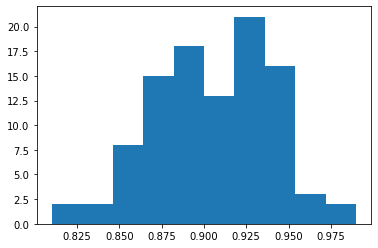

In [42]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()
  

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

# Выполнение

Рассуждение: действительно, непонятно, как могла получиться столь высокая accuracy, ведь пространство признаков и метки фомируются неазвисимо (и случайно). Получается, следует ожидать accuracy около 50%.

Если честно, до этого у меня были иные рассуждения: я предполагал, что проблема в том, как мы выбираем признаки. Однако, как справедливо было замечено на семинаре, нет никакой проблемы в том, что мы ищем признаки, которые имеют хоть какую-то связь с метками. Так что отбор признаков в норме.

Здесь причина гораздо глубже и тоньше. Задача кросс-валидации — проверка обобщающей спосбности модели, возможность контроля переобучения. В данном случае речь идёт о k-fold кросс-валидации, когда мы разделяем наш датасет на k равных частей, откладываем одну, обучаем модель на (k-1) частях и тестируем на одной оставшейся, а затем повторяем эту процедуру, откладывая другую часть. И вроде бы именно так всё происходит в этом домашнем задании.

Однако процесс обучения модели включает в себя отбор параметров, а мы это сделали один раз для всего датасета, а при кросс-валидации лишь контролировали, насколько хорошо проводится разделяющая плоскость. Так что это неправильный тест: нужно отбирать наилучшие параметры на (k-1) части, а затем тестировать на оставшейся части. Проверим, изменится ли accuracy при подобном рассмотрении!

In [43]:
x = ["a", "b", "c", "d"]
Y = [16,17,18,19]
kf = KFold(n_splits=2)
for train,test in kf.split(x,Y):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]


In [44]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)
accuracy = []

#Производим разбиение датасета
kf = KFold(10)
for train,test in kf.split(X):
    
    X_best = FeatureSelector(num_features_best).fit_transform(X[train], y[train])
    best_features_ids = FeatureSelector(num_features_best).fit(X[train], y[train])
    
    X_best_test = X[test][:,best_features_ids]
    
    model = LinearSVC()
    model.fit(X_best,y[train])
    
    y_pred = model.predict(X_best_test)    
    accuracy.append((y_pred == y[test]).mean())
    
print(np.array(accuracy).mean())            
    

0.55


Ну и аналогично повторим это много раз.

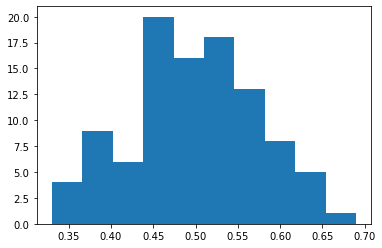

In [45]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)
  accuracy = []

  kf = KFold(10)
  for train,test in kf.split(X):
    X_best = FeatureSelector(num_features_best).fit_transform(X[train], y[train])
    best_features_ids = FeatureSelector(num_features_best).fit(X[train], y[train])

    X_best_test = X[test][:,best_features_ids]

    model = LinearSVC()
    model.fit(X_best,y[train])

    y_pred = model.predict(X_best_test)    
    accuracy.append((y_pred == y[test]).mean())
    
  return np.array(accuracy).mean()           
results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Получили то, что и ожидали! Некоторое распределение со средним, близким к 50%.